### Data

In the data section we will consider what raw data may look like (as ours is already reasonably processed), along with doing some preliminary data analysis and some pre-processing.

#### Raw Data

As we are using the [Kaggle Emotions](https://www.kaggle.com/datasets/nelgiriyewithana/emotions/data), the data is not in a raw form and is already laid out in a tabular format. If you are collecting data yourself, it is likely never going to be this neat. It could be in the form of HTML content that you must extract, or one long string with (hopefully) meaningful ways to split it.

Here is some sample data from HTML and then the same data in some string format.
```
<div class="tweet">
    <div class="username">User1</div>
    <div class="date">2024-03-14</div>
    <div class="text">i hope we do otherwise im going to be feeling a little foolish</div>
    <div class="likes">17</div>
    <div class="retweets">5</div>
</div>

"/tUser1/n/n2024-03-14</n/n/ni hope we do otherwise im going to be feeling a little foolish/n17/t5"
```

We can see in the HTML we can derive some of the structure of the content from the tags. We can parse the HTML as shown below.

In [2]:
from bs4 import BeautifulSoup

raw_data_string = """
<div class="tweet">
    <div class="username">User1</div>
    <div class="date">2024-03-14</div>
    <div class="text">i hope we do otherwise im going to be feeling a little foolish</div>
    <div class="likes">17</div>
    <div class="retweets">5</div>
</div>
"""

# Parse the raw data string using BeautifulSoup
soup = BeautifulSoup(raw_data_string, 'html.parser')

# Find all the div elements of class tweet.
tweet_divs = soup.find_all('div', class_='tweet')

# Iterate over each tweet div and extract relevant information
for tweet_div in tweet_divs:
    username = tweet_div.find('div', class_='username').text.strip()
    date = tweet_div.find('div', class_='date').text.strip()
    text = tweet_div.find('div', class_='text').text.strip()
    likes = int(tweet_div.find('div', class_='likes').text.strip())
    retweets = int(tweet_div.find('div', class_='retweets').text.strip())
    
text

'i hope we do otherwise im going to be feeling a little foolish'

We can see that the text can be extracted from the above. The other raw input could be parsed by using Python's .split() on the String instance. There are many ways to parse raw data, so try to understand the format your data is coming in first to allow you to best parse it.

### Data Analysis

Now we want to look at the data and get a bit of an understanding of what we are working with. We can start by looking at the distribution of class labels.

First we need to load in the data

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns

# Get the path to the data file
data_path = Path.cwd().parent / "Resources" / "data.csv"

# Read in the csv
df = pd.read_csv(data_path, index_col=["Unnamed: 0"])

# Create a mapping to add the string version of the labels to the data
label_mapping = {
    0: "Sadness",
    1: "Joy",
    2: "Love",
    3: "Anger",
    4: "Fear",
    5: "Surprise"
}

# Create a class_label feature
df['class_label'] = df['label'].map(label_mapping)

# Get the counts of each class
class_counts = df['class_label'].value_counts()

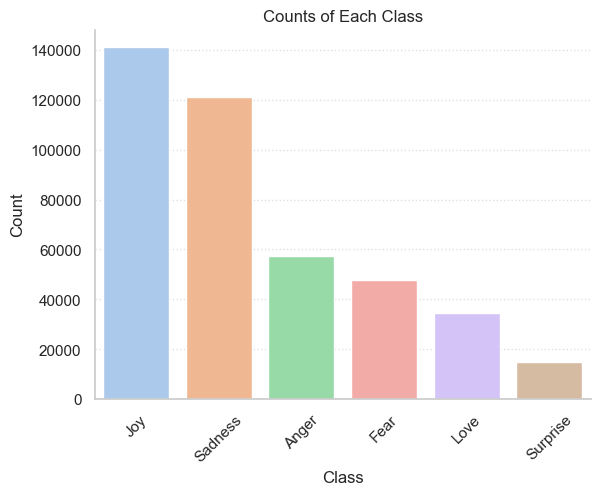

In [27]:
# Create a bar chart of the counts
sns.set(style="whitegrid")
sns.barplot(x=class_counts.index, y=class_counts.values, palette='pastel', order=class_counts.index)
plt.title('Counts of Each Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.gca().yaxis.grid(True, linestyle=':', alpha=0.6)
sns.despine()
plt.show()

We can see from the above that the classes are not balanced, with joy having ~140k and Surprise having ~15k. This is important to know as it can inform our decisions when creating a model.

Now we can have a look at the text content itself. We may want to understand how long the average piece of text from each class is, in terms of both words and characters. This will allow us to monitor input when deploying the model and determine if the data we are inferencing on is different to the data we trained on.

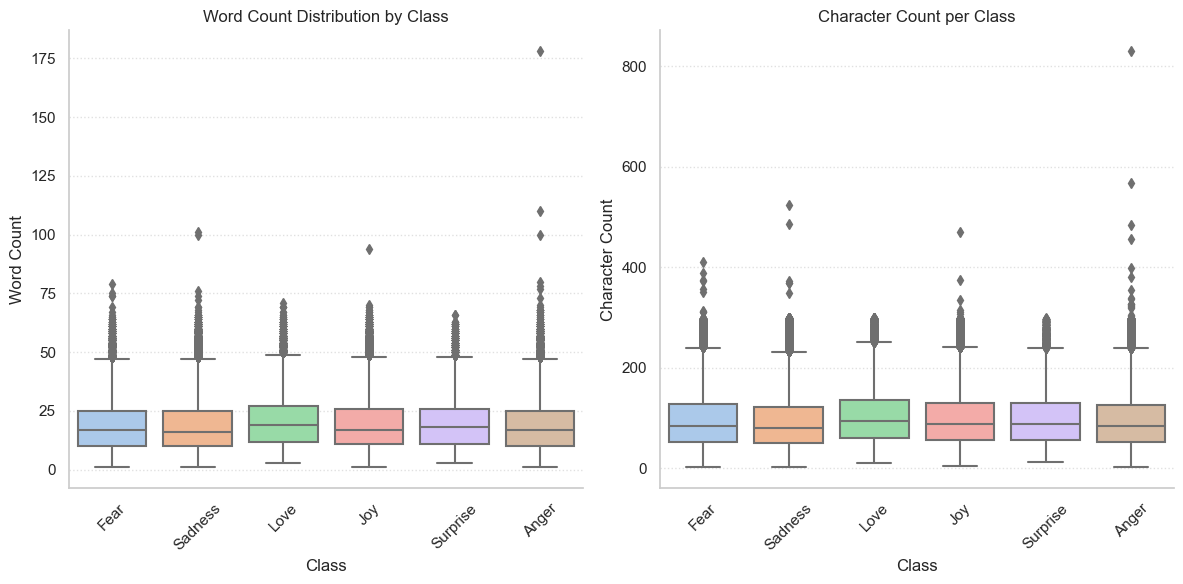

Counts of each class:
Joy         141067
Sadness     121187
Anger        57317
Fear         47712
Love         34554
Surprise     14972
Name: class_label, dtype: int64

Average words and characters in each class:
             word_count  char_count
class_label                        
Anger         19.032713   96.017517
Fear          18.961687   96.690581
Joy           19.536915   98.746050
Love          20.823523  104.689153
Sadness       18.488509   93.127555
Surprise      19.744122   99.685079


In [36]:
# Calculate average words and characters in each class
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['char_count'] = df['text'].apply(lambda x: len(x))

avg_word_char_per_class = df.groupby('class_label').agg({'word_count': 'mean', 'char_count': 'mean'})

# Create box and whisker plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.set(style="whitegrid")

# Box plot for word count
sns.boxplot(x='class_label', y='word_count', data=df, ax=axes[0], palette='pastel')
axes[0].set_title('Word Count Distribution by Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Word Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Rotate x-axis ticks by 45 degrees
axes[0].yaxis.grid(True, linestyle=':', alpha=0.6)  # Add grid lines to the y-axis
sns.despine(ax=axes[0])

# Box plot for character count
sns.boxplot(x='class_label', y='char_count', data=df, ax=axes[1], palette='pastel')
axes[1].set_title('Character Count per Class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Character Count')
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Rotate x-axis ticks by 45 degrees
axes[1].yaxis.grid(True, linestyle=':', alpha=0.6)  # Add grid lines to the y-axis
sns.despine(ax=axes[1])

plt.tight_layout()
plt.show()

# Print counts of each class and average words and characters
print("Counts of each class:")
print(class_counts)
print("\nAverage words and characters in each class:")
print(avg_word_char_per_class)

We can see that all of the classes seem similar enough in terms of average words, all in the region of 18-20 on average. We can see that the anger class seems to have a lot of outliers. Using these average, we can determine if a new piece of text is likely outside of the data distibution for training. We can also look at the .describe() method to get some summary statistics of our DataFrame.

In [34]:
df.describe()

,label,word_count,char_count
count,416809.000000,416809.000000,416809.000000
mean,1.554271,19.211015,97.028397
std,1.490453,11.051049,56.198232
min,0.000000,1.000000,2.000000
25%,0.000000,11.000000,54.000000
50%,1.000000,17.000000,86.000000
75%,3.000000,25.000000,128.000000
max,5.000000,178.000000,830.000000
